<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear 2: Feature Engineering, Validation, Experimentation

_Authors: Bryce Macher (DC), Joseph Nelson (DC), Kevin Markham (DC)_

---

<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
### Learning Objectives
- Review linear regression and baselining
- Discuss feature engineering, including categorical inclusion in models
- Define error due to bias and error due to variance, and the bias-variance tradeoff
- Describe what overfitting and underfitting means in the context of model building.
- Grasp why train/test split is necessary.
- Explore k-folds, LOOCV, and three split methods.
- Set up an experiment that compares model strategies

## Review: Linear Regression

In [26]:
#Import the standard modules, as well as sklearn modules for linear regression and metrics
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
#Read in the bikeshare data from csv
bikes = pd.read_csv('./data/bikeshare.csv')

In [5]:
#Profile the data: How many instances, nulls, data type, size
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


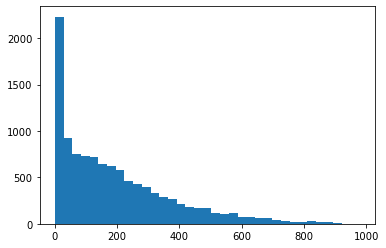

In [9]:
#What is the distribution of the data - visualize it
plt.hist(bikes["count"],bins = 'scott');

In [33]:
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,baseline
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,145.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,145.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,145.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,145.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,145.0


In [11]:
#Based on the above, which would you use to baseline your model, the mean or the median? 
print(bikes['count'].mean())
print(bikes['count'].median())

191.57413191254824
145.0


In [21]:
#Create a feature in your dataframe called 'baseline' that just inserts the median
bikes['baseline'] = bikes['count'].median()
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,baseline
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,145.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,145.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,145.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,145.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,145.0


In [31]:
#Calculate the MAE and RMSE - why are they different, and why would we use one over the other? 
#mae = np.abs(bikes['count'] - bikes['baseline']).sum()/bikes.shape[0]
print(mae(bikes['count'],bikes['baseline']))
print(np.sqrt(mse(bikes['count'],bikes['baseline']))) # RSME has the same unit as y, i.e., count

138.01616755465736
187.02793547928005


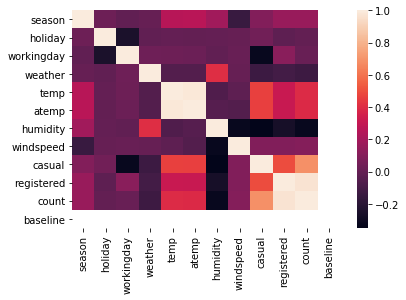

In [32]:
#Create a correlation heatmap. What features would you choose for your model, and why? 
sns.heatmap(bikes.corr())

In [44]:
#Build a linear regression model
# again, pick the one with the highest correlation
X = bikes[['registered','windspeed','humidity']]
y = bikes['count']
lr1 = LinearRegression()
lr1.fit(X,y)
count_pred = lr1.predict(X).reshape(-1,1)
print(mae(y,count_pred))
print(np.sqrt(mse(y,count_pred)))  # 41 bikes off based on rsme and 26 bikes off based on mae
from sklearn.metrics import r2_score
r2_score(y,count_pred) # overfit model with really high R2

26.036600397513975
41.85615753065923


0.9466040242636621

In [41]:
#Add your modeled data to your dataframe as a feature called 'regression1'
'''
Adding the array that is output from your lr.predict() will look something like: df['regression1'] = y_pred
'''
bikes['regression1'] = lr1.predict(X)

In [228]:
#Calculate the MAE and RMSE


126.64996567287699
166.42507300338386


In [132]:
#What is the percentage change in your model vs. the mean or median? 
(187-166)/187

'''we reduced our error by 11%'''

0.11229946524064172

## Feature Engineering to Improve Performance!

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.

### Categorical Features
scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?
- __Ordered categories__: Transform them to sensible numeric values (example: small=1, medium=2, large=3) (Not recommended!)
- __Unordered categories__: Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?
- __Ordered categories__: weather (already encoded with sensible numeric values)
- __Unordered categories__: season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.



In [45]:
#Create dummy variables using get_dummies from pandas
season_dummies = pd.get_dummies(bikes.season, prefix='season',drop_first= True)

In [46]:
# Print five random rows to inspect that new DataFrame
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
3709,0,1,0
6741,0,0,0
9848,0,0,1
1410,1,0,0
10672,0,0,1


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

In [133]:
#Drop the first season column here
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

#Re-inspect the dataframe
season_dummies.sample(n=5, random_state = 1)

,season_2,season_3,season_4
3709,0,1,0
6741,0,0,0
9848,0,0,1
1410,1,0,0
10672,0,0,1


In [134]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes, season_dummies], axis=1)

# Print 5 random rows.
bikes_dummies.sample(n=5, random_state=1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,baseline,regression1,season_2,season_3,season_4
3709,2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,145.0,273.862391,0,1,0
6741,2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,145.0,156.258073,0,0,0
9848,2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,145.0,266.256242,0,0,1
1410,2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,145.0,263.348132,1,0,0
10672,2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,145.0,181.787263,0,0,1


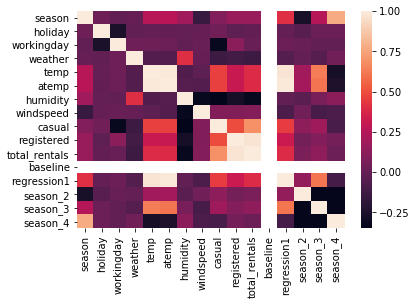

In [135]:
#Now re-run your correlation heatmap. Are any of these features useful? 
sns.heatmap(bikes_dummies.corr())

In [232]:
#Create a linear regression using an X Matrix that includes your features in linear1 AND all of the seasons
feats = ['atemp', 'season_2', 'season_3', 'season_4']
X = bikes_dummies[feats]
y = bikes_dummies.total_rentals

linear2 = LinearRegression()
linear2.fit(X, y)
y_pred = linear2.predict(X)

In [233]:
#Measure the MSE and/or RMSE
np.sqrt(mse(y, y_pred))

164.07364742403442

In [234]:
#Compare it to your baseline and previous model
(166-164)/166

'''A 1% reduction in error... but at what cost?'''

'A 1% reduction in error... but at what cost?'

<a id="bias-and-variance-trade-off"></a>
## Bias and Variance Trade-Off
---

The **bias-variance tradeoff** is widely used in machine learning as a conceptual way of comparing and contrasting different models. We only have a few methods that are able to compare all machine learning models. The others are more mathematical.

**Bias** is error stemming from incorrect model assumptions.
- Example: Assuming data is linear when it has a more complicated structure.

**Variance** is error stemming from being overly sensitive from changes to the training data.
- Example: Using the training set exactly (e.g. 1-NN) for a model results in a completely different model -- even if the training set differs only slightly.


As model complexity **increases**:
- Bias **decreases**. (The model can more accurately model complex structure in data.)
- Variance **increases**. (The model identifies more complex structures, making it more sensitive to small changes in the training data.)

<a id="bias-variance"></a>
### Bias? Variance?

**Conceptual Definitions**
- **Bias**: How close are predictions to the actual values?
  - Roughly, whether or not our model aims on target.
  - If the model cannot represent the data's structure, our predictions could be consistent, but will not be accurate.
- **Variance**: How variable are our predictions?
  - Roughly, whether or not our model is reliable.
  - We will make slightly different predictions given slightly different training sets.

![](./assets/biasVsVarianceImage.png)

- Visually, we are building a model where the bulls-eye is the goal.
- Each individual hit is one prediction based on our model.
- Critically, the success of our model (low variance, low bias) depends on the training data present.

**Expressing bias and variance mathematically:**

It can be helpful understanding these terms by looking at how we can decompose the total error into them mathematically. (We will skip the derivations for now!)

Let's define the error of our predictor as the expected value of our squared error. Note this error is not based on any particular fitted model, but on the family of potential models given a dataset (i.e. all fitted models made from all possible subsets of data).

$$E[(y - \hat{f}(x))^2] = Bias[\hat{f}(x)]^2 + Var[\hat{f}(x)] + \sigma^2$$

This states the expected error is based on only three components: **bias**, **variance**, and **irreducible error**.

Breaking the bias and variance down further:

$$Bias[\hat{f}(x)] = E[\hat{f}(x) - f(x)].$$

- The bias is just the average expected distance between our predictor and actual values.

$$Var[\hat{f}(x)] = E[\hat{f}(x)^2] - E[\hat{f}(x)]^2.$$

- The variance is how much our predictions vary about the mean. ($E[\hat{f}(x)]$ is our predictor's mean prediction.)

- The irreducible error stems from noise in the problem itself.

From the math above, we can answer a few common questions:

Can a model have high bias given one dataset and low bias for another?
- Yes. If our data is linearly related, for example, it will have low bias on a linear model! However, in general across all datasets very few are accurately described with a linear model. So, in general we say a linear model has high bias and low variance.

Is the MSE for a fitted linear regression the same thing as the bias?
- It's close, but bias does not apply to a specific fitted model. Bias is the expected error of a model no matter what subset of the data it is fit on. This way, if we happen to get a lucky MSE fitting a model on a particular subset of our data, this does not mean we will have a low bias overall.

<a id="exploring-the-bias-variance-tradeoff"></a>
### Exploring the Bias-Variance Trade-Off

<a id="brain-and-body-weight-mammal-dataset"></a>
### Brain and Body Weight Mammal Data Set

This is a [data set](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body (in kg) and the brain (in g) for 62 mammal species. We'll use this dataset to investigate bias vs. variance. Let's read it into Pandas and take a quick look:

In [47]:
path = 'data/mammals.txt'
cols = ['brain','body']
mammals = pd.read_table(path, sep='\t', names=cols, header=0)
mammals.head()

,brain,body
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


In [48]:
mammals.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 200 kg.

In [49]:
# Only keep rows in which the body weight is less than 200 kg.
mammals = mammals[mammals.body < 200]
mammals.shape

(51, 2)

We're now going to pretend that there are only 51 mammal species in existence. In other words, we are pretending that this is the entire data set of brain and body weights for **every known mammal species**.

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

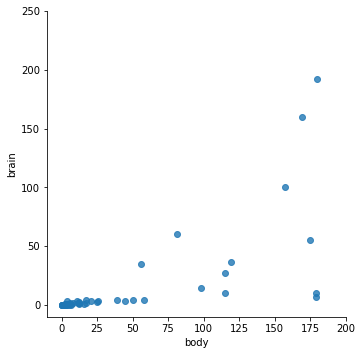

In [50]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, fit_reg=False);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

There appears to be a relationship between brain and body weight for mammals.

<a id="making-a-prediction"></a>
### Making a Prediction

<a id="linear-regression-quick-review"></a>
#### Linear Regression: A Quick Review

![](./assets/linear-residuals.png)

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species we can find and calculate an **average body weight of 100 kgs**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

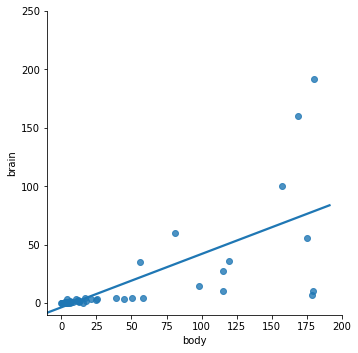

In [151]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 45 g, as that's the approximate y value when x=100.

This is known as a "linear model" or a "linear regression model."

<a id="making-a-prediction-from-a-sample"></a>
## Making a Prediction From a Sample

Earlier, we assumed that this dataset contained every known mammal species. That's very convenient, but **in the real world, all you ever have is a sample of data**. This may sound like a contentious statement, but the point of machine learning is to generalize from a sample to the population. If you already have data for the entire population, then you have no need for machine learning -- you can apply statistics directly and get optimal answers!

Here, a more realistic situation would be to only have brain and body weights for (let's say) half of the 51 known mammals.

When that new mammal species (with a body weight of 100 kg) is discovered, we still want to make an accurate prediction for its brain weight, but this task might be more difficult, as we don't have all of the data we would ideally like to have.

Let's simulate this situation by assigning each of the 51 observations to **either universe 1 or universe 2**:

In [152]:
# Set a random seed for reproducibility.
np.random.seed(12345)

# Randomly assign every observation to either universe 1 or universe 2.
mammals['universe'] = np.random.randint(1, 3, len(mammals))
mammals.head()

,brain,body,universe
0,3.385,44.5,1
1,0.480,15.5,2
2,1.350,8.1,2
4,36.330,119.5,2
5,27.660,115.0,1


**Important:** We only live in one of the two universes. Both universes have 51 known mammal species, but each universe knows the brain and body weight for different species.

We can now tell Seaborn to create two plots in which the left plot only uses the data from **universe 1** and the right plot only uses the data from **universe 2**:

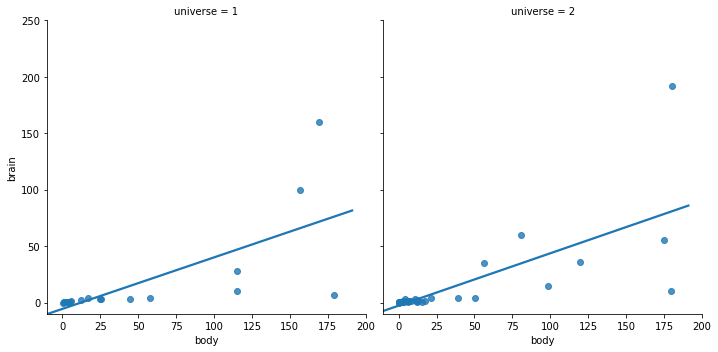

In [153]:
# col='universe' subsets the data by universe and creates two separate plots.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 45 g.

It's easier to see the degree of similarity by placing them on the same plot:

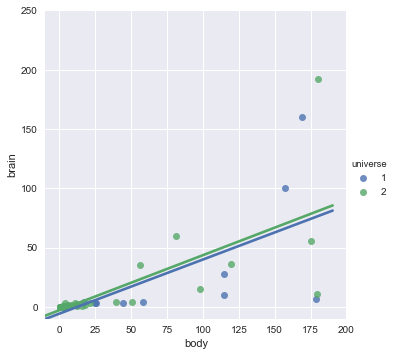

In [9]:
# hue='universe' subsets the data by universe and creates a single plot.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

So, what was the point of this exercise? This was a visual demonstration of a high-bias, low-variance model.

- It's **high bias** because it doesn't fit the data particularly well.
- It's **low variance** because it doesn't change much depending on which observations happen to be available in that universe.

<a id="lets-try-something-completely-different"></a>
### Let's Try Something Completely Different

What would a **low bias, high variance** model look like? Let's try polynomial regression with an eighth-order polynomial.

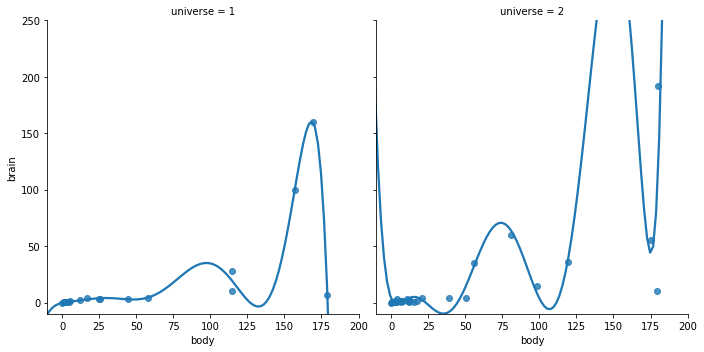

In [154]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

- It's **low bias** because the models match the data effectively.
- It's **high variance** because the models are widely different, depending on which observations happen to be available in that universe. (For a body weight of 100 kg, the brain weight prediction would be 40 kg in one universe and 0 kg in the other!)

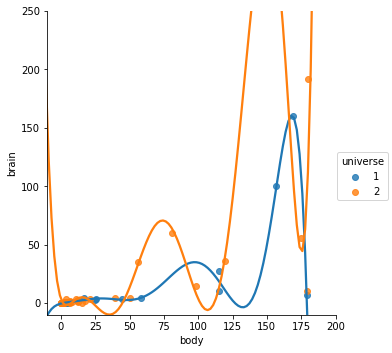

In [11]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

<a id="balancing-bias-and-variance"></a>
## Balancing Bias and Variance
Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model** and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

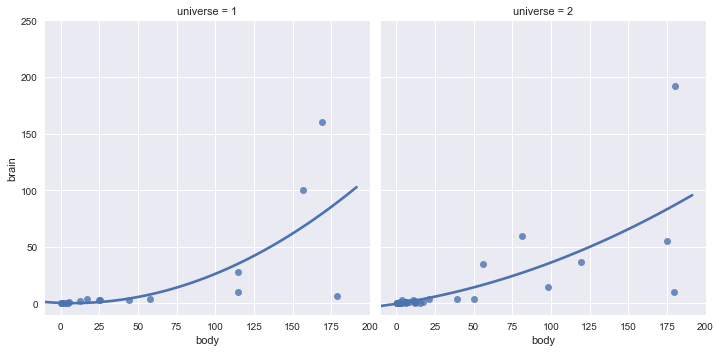

In [11]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=2);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

This seems better. In both the left and right plots, **it fits the data well, but not too well**.

This is the essence of the **bias-variance trade-off**: You are seeking a model that appropriately balances bias and variance and thus will generalize to new data (known as "out-of-sample" data).

We want a model that best balances bias and variance. It
should match our training data well (moderate bias) yet be low variance for out-of-sample data (moderate variance).

- Training error as a function of
complexity.
- Question: Why do we even
care about variance if we
know we can generate a
more accurate model with
higher complexity?

### Can we obtain a zero-bias, zero-variance model?

No! If there is any noise in the data-generating process, then a zero-variance model would not be learning from the data. Additionally, a model only has zero bias if the true relationship between the target and the features is hard-coded into it. If that were the case, you wouldn't be doing machine learning -- it would be similar to trying to predict today's temperature by using today's temperature!

---

<a id="train-test-split"></a>
## Train-test-split

For the rest of the lab, we will look at three evaluation procedures for predicting model out-of-sample accuracy:

1. **Train on the entire dataset** should never be done to estimate model accuracy on out-of-sample data! After all, training error can be made arbitrarily small or large. You might train on the entire dataset as the very last step when a model is chosen, hoping to make the final model as accurate as possible. Or, you could use this to estimate the degree of overfitting.
2. **Train-test-split** is useful if cross-validation is not practical (e.g. it takes too long to train). It is also useful for computing a quick confusion matrix. You could also use this as a final step after the model is finalized (often called evaluating the model against a **validation set**).
3. **Cross-validation** is the gold standard for estimating accuracy and comparing accuracy across models.
4. **Three-way split** combines cross-validation and the train-test-split. It takes an initial split to be used as a final validation set, then uses cross-validation on the rest.

We run into a problem when powerful models can perfectly fit the data on which they are trained. These models are **low bias** and **high variance**. However, we can't observe the variance of a model directly, because we only know how it fits the data we have rather than all potential samples.

**Solution:** Create a procedure that **estimates** how well a model is likely to perform on out-of-sample data and use that to choose between models.

- Before, we have been splitting the data into a **single training group** and a **single test group**.

- Now, to estimate how well the model is likely to perform on out-of-sample data, we will create **many training groups** and **many test groups** then fit **many models**.

**Note:** These procedures can be used with **any machine learning model**.


**The Holdout Method: Train/Test Split**
- **Training set**: Used to train the regressor.
- **Testing set**: Used to estimate the error rate of the trained classifier.
- **Advantages**: Fast, simple, computationally inexpensive.
- **Disadvantages** Eliminates data, imperfectly splits.

<a id="evaluation-procedure--train-and-test-on-the-entire-dataset-do-not-do-this"></a>
### Evaluation Procedure #1: Train and Test on the Entire Data Set (Do Not Do This)

1. Train the model on the **entire data set**.
2. Test the model on the **same data set** and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

#### Load in the Boston data.

In [51]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

In [52]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### Easy way to set up a dataframe

In [53]:
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['MEDV'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


#### Create X and y variable to stores the feature matrix and response from the Boston data.

In [54]:
# Create a DataFrame for both parts of data; don't forget to assign column names.
X = boston.data
y = boston.target

#### Prepare a feature matrix (X) and response (y)  for scikit-learn.

In [55]:
# create feature matrix (X)
feature_cols = boston_df.columns.drop(['MEDV'])
X = boston_df[feature_cols]

# create response vector (y)
y = boston_df.MEDV

#### Import linear regression, instantiate, fit, and preview predictions.

In [56]:
# Import the class.
from sklearn.linear_model import LinearRegression

# Instantiate the model.
lr = LinearRegression()

# Train the model on the entire data set.
lr.fit(X, y)

# Predict the response values for the observations in X ("test the model").
y_pred = lr.predict(X)

To evaluate a model, we also need an **evaluation metric:**

- A numeric calculation used to **quantify** the performance of a model.
- The appropriate metric depends on the **goals** of your problem.

The most common choices for regression problems are:

- **R-squared**: The percentage of variation explained by the model (a "reward function," as higher is better).
- **Mean squared error**: The average squared distance between the prediction and the correct answer (a "loss function," as lower is better).

In this case, we'll use mean squared error because it is more interpretable in a predictive context.

#### Compute mean squared error using a function from `metrics`.

In [57]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y, y_pred))

21.894831181729202


This is known as the **training mean squared error** because we are evaluating the model based on the same data we used to train the model.

<a id="problems-with-training-and-testing-on-the-same-data"></a>
### Problems With Training and Testing on the Same Data

- Our goal is to estimate likely performance of a model on **out-of-sample data**.
- But, maximizing the training mean squared error rewards **overly complex models** that won't necessarily generalize.
- Unnecessarily complex models **overfit** the training data.
    - They will do well when tested using the in-sample data.
    - They may do poorly with out-of-sample data.
    - They learn the "noise" in the data rather than the "signal."
    - From Quora: [What is an intuitive explanation of overfitting?](http://www.quora.com/What-is-an-intuitive-explanation-of-overfitting/answer/Jessica-Su)

**Thus, the training MSE is not a good estimate of the out-of-sample MSE.**

<a id="evaluation-procedure--traintest-split"></a>
### Evaluation procedure #2: Train/Test Split

1. Split the data set into two pieces: a **training set** and a **testing set**.
2. Train the model on the **training set**.
3. Test the model on the **testing set** and evaluate how well we did.

Often a good rule-of-thumb is 70% training/30% test, but this can vary based on the size of your dataset. For example, with a small dataset you would need to use as much training data as possible (in return, your test accuracy will be more variable).

What does this accomplish?

- Models can be trained and tested on **different data** (We treat testing data like out-of-sample data).
- Response values are known for the testing set and thus **predictions can be evaluated**.

This is known as the **testing mean squared error** because we are evaluating the model on an independent "test set" that was not used during model training.

**The testing MSE is a better estimate of out-of-sample performance than the training MSE.**

#### Understanding the `train_test_split` Function

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [60]:
# Before splitting
print(X.shape)

# After splitting
print(X_train.shape)
print(X_test.shape)

(506, 13)
(379, 13)
(127, 13)


In [61]:
# Recall that (1,) is a tuple. 
# The trailing comma distinguishes it as being a tuple, not an integer.

# Before splitting
print(y.shape)

# After splitting
print(y_train.shape)
print(y_test.shape)

(506,)
(379,)
(127,)


![train_test_split](./assets/train_test_split.png)

#### Understanding the `random_state` Parameter

The `random_state` is a pseudo-random number that allows us to reproduce our results every time we run them. However, it makes it impossible to predict what are exact results will be if we chose a new `random_state`.

`random_state` is very useful for testing that your model was made correctly since it provides you with the same split each time. However, make sure you remove it if you are testing for model variability!

In [62]:
# WITHOUT a random_state parameter:
#  (If you run this code several times, you get different results!)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Print the first element of each object.
print(X_train.head(1))

        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
477  15.0234  0.0   18.1   0.0  0.614  5.304  97.3  2.1007  24.0  666.0   

     PTRATIO       B  LSTAT  
477     20.2  349.48  24.91  


In [63]:
# WITH a random_state parameter:
#  (Same split every time! Note you can change the random state to any integer.)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

# Print the first element of each object.
print(X_train.head(1))
print(X_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
182  0.09103  0.0   2.46   0.0  0.488  7.155  92.2  2.7006  3.0  193.0   

     PTRATIO       B  LSTAT  
182     17.8  394.12   4.82  
        CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  RAD    TAX  \
173  0.09178  0.0   4.05   0.0  0.51  6.416  84.1  2.6463  5.0  296.0   

     PTRATIO      B  LSTAT  
173     16.6  395.5   9.04  
182    37.9
Name: MEDV, dtype: float64
173    23.6
Name: MEDV, dtype: float64


![Bias-variance tradeoff](./assets/bias_variance.png)

#### Go back to Step 1 and try adding new variables and transformations.

In [64]:
boston_df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


- **Training error**: Decreases as model complexity increases (lower value of k).
- **Testing error**: Is minimized at the optimum model complexity.

<a id="comparing-test-performance-with-a-null-baseline"></a>
### Comparing Test Performance With a Null Baseline

When interpreting the predictive power of a model, it's best to compare it to a baseline using a dummy model, sometimes called a ZeroR model or a baseline model. A dummy model is simply using the mean, median, or most common value as the prediction. This forms a benchmark to compare your model against and becomes especially important in classification where your null accuracy might be 95 percent.

For example, suppose your dataset is **imbalanced** -- it contains 99% one class and 1% the other class. Then, your baseline accuracy (always guessing the first class) would be 99%. So, if your model is less than 99% accurate, you know it is worse than the baseline. Imbalanced datasets generally must be trained differently (with less of a focus on accuracy) because of this.

You can alternatively use simple models to achieve baseline results, for example nearest neighbors or a basic unigram bag of words for text data.

#### Examine the baseline mean squared error using a null model.
How does this compare to what we achieved with linear regression. Is our model making an actual improvement?

In [259]:
y_null = np.full(y_test.shape[0], y_test.mean())
y_null

array([21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41338583,
       21.41338583, 21.41338583, 21.41338583, 21.41338583, 21.41

In [260]:
# Use .apply() to broadcast a mean for every prediction.
print(metrics.mean_squared_error(y_test, y_null))

70.0271436542873


## Returning to the Bikeshare Data

In [284]:
#Choose your features


In [285]:
#Set up your X Matrix and y vector


In [276]:
#Create the training and test set


In [287]:
#Build your model using the training set


#Create your prediction using the X_test


In [289]:
#Score the MAE and MSE of your model. Is it good? 


164.1263822956672


In [293]:
#Create a new feature called 'regression3' in your data frame that imputes from your new regression model
'''
Syntax will look something like df['regression3'] = lr.predict(df.Total_Rentals)
'''


In [295]:
#Score the MAE and RMSE of your model across the entire dataframe. Why did it change?


187.41505410596767

In [ ]:
#How does it compare to your previous model? How does it compare to the mean/median imputation?


<a id="k-folds-cross-validation"></a>
## K-Folds Cross-Validation
---

Train/test split provides us with helpful tool, but it's a shame that we are tossing out a large chunk of our data for testing purposes.

**How can we use the maximum amount of our data points while still ensuring model integrity?**

1. Split our data into a number of different pieces (folds).
2. Train using `k-1` folds for training and a different fold for testing.
3. Average our model against EACH of those iterations.
4. Choose our model and TEST it against the final fold.
5. Average all test accuracies to get the estimated out-of-sample accuracy.

Although this may sound complicated, we are just training the model on k separate train-test-splits, then taking the average of the resulting test accuracies!

![](./assets/cross_validation_diagram.png)

<a id="intro-to-cross-validation-with-the-boston-data"></a>
### Intro to Cross-Validation With the Boston Data

#### Create a cross-valiation with five folds.

In [296]:
from sklearn.model_selection import KFold, cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)


27343.014197863937
0.1667665766707828


While the cross-validated approach here generated more overall error, which of the two approaches would predict new data more accurately — the single model or the cross-validated, averaged one? Why?



**Answer**: 

....

In [7]:
#Now try it with your last model from your bike share data. 
